<a href="https://colab.research.google.com/github/DaniilSysoev/opisis_sem_14/blob/main/%D0%9E%D0%BF%D0%B8%D1%81%D0%B8%D1%81_%D1%81%D0%B5%D0%BC_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Формирование канальных сигналов в системах передачи с временным разделением каналов. Импульсная модуляция. Формирование АИМ, ШИМ и ФИМ сигналов.</h1>

<h2>На основе заданного первичного сигнала сформировать канальный сигнал с применением АИМ-1, АИМ-2, ШИМ-1 и ФИМ-1. Представить графически полученные сигналы во временной и частотной областях.</h2>

Временной интервал, мс 50


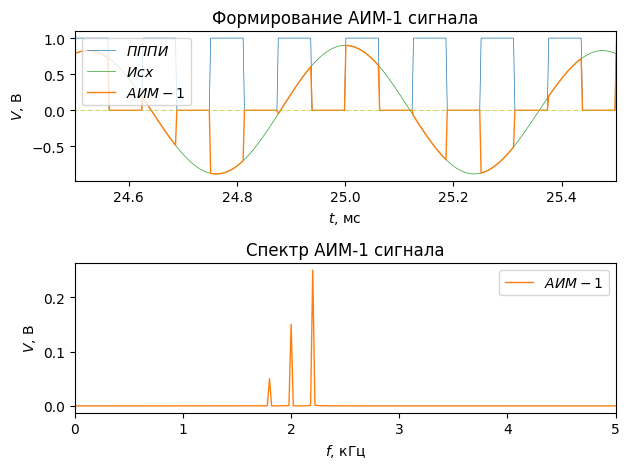

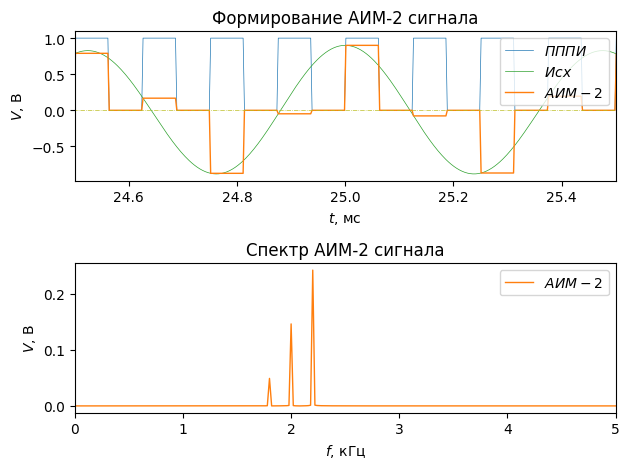

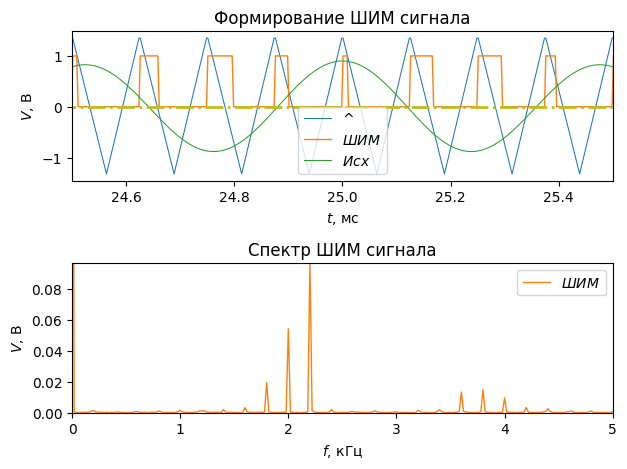

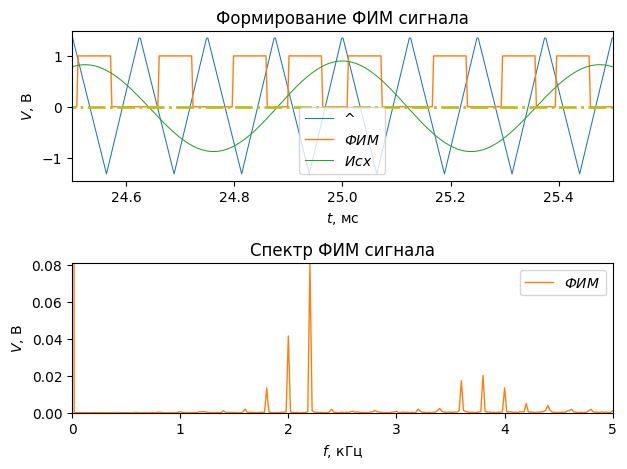

In [4]:
import numpy as np
from math import *
import matplotlib.pyplot as plt

def f2w(f):
    return 2.0*pi*f

#Короткий широкополосный импульс
def wb_pulse(t, Tc, fn, fv):
    freq = (fv + fn) * 0.5
    dt = 1.0 / (fv-fn)
    return exp(-(0.5*Tc-t)**2/dt**2*0.5)*sin(2.0*pi*freq*t)

pulse = False
auto_scale = True #Автомасштабирование графиков сигналов по времени и частоте

npp = 50
fc = 2 #Частота модулирующего сигнала [кГц]

T = float(input('Временной интервал, мс '))
n = int(8*T)*npp #Число временных отсчетов (8 кГц - удвоенная макс. частота в спектре сигнала КТЧ)

#Массивы отсчетов модулирующего и пилообразного сигналов
sign = np.array([0.0] * n) #Модулирующий информационный сигнал
sigt = np.array([0.0] * n) #Пилообразный сигнал для формирования импульсно-модулированных сигналов

#ПППИ (periodic sequence of rectangular pulses)
psrp = [0] * n 

#Массивы модулированных импульсных сигналов
pa1 = [0] * n #АИМ сигнал 1 рода
pa2 = [0] * n #АИМ сигнал 2 рода
pwm = [0] * n #ШИМ сигнал
ppm = [0] * n #ФИМ сигнал

#Массив моментов времени для отсчетов сигналов
time = [0] * n

#Шаг дискретизации по времени
h = T / (n-1)

#Формирование модулирующего сигнала
for i in range(n):
    time[i] = i*h
    sign[i] = 0.1*cos(f2w(fc-0.2)*time[i])+0.3*cos(f2w(fc)*time[i])+0.5*cos(f2w(fc+0.2)*time[i]) if not pulse else wb_pulse(time[i], T, 0.3, 3.4)

mins = sign.min()
maxs = sign.max()

mins*= 1.5
maxs*= 1.5

#Формирование ПППИ и АИМ сигнала
for i in range(n//npp):
    for j in range(npp):
        indx = i*npp+j
        psrp[indx] = 1.0 if j < 0.5*npp else 0 #Формирование ПППИ
        pa1[indx] = psrp[indx]*sign[indx]
        pa2[indx] = psrp[indx]*sign[i*npp]
        if j <= npp//2:
            sigt[indx] = mins-(maxs-mins)*(time[indx]-time[i*npp+npp//2])/(time[i*npp+npp//2]-time[i*npp])
        else:
            sigt[indx] = maxs-(maxs-mins)*(time[indx]-time[i*npp+npp-1])/(time[i*npp+npp//2]-time[i*npp+npp-1])

#Формирование ШИМ сигнала
for i in range(n//npp):
    c = 1
    for j in range(npp-1):
        indx = i*npp+j
        if (sigt[indx]-sign[indx])*(sigt[indx+1]-sign[indx+1]) <= 0:
            c = 0
        pwm[indx] = c

#Формирование ФИМ сигнала
for i in range(n//npp):
    k = 0
    for j in range(npp-1):
        indx = i*npp+j
        if (sigt[indx] <= sign[indx]) and (sigt[indx+1] >= sign[indx+1]):
            k = indx
            break
        if (sigt[indx] >= sign[indx]) and (sigt[indx+1] <= sign[indx+1]):
            k = indx
            break
    for j in range(npp//2):
        indx = k+j
        ppm[indx] = 1

#Расчет спектра сигалов
sp_freq = np.fft.fftfreq(n, T/n)

sp_pa1 = np.fft.fft(pa1)
sp_pa2 = np.fft.fft(pa2)
sp_pwm = np.fft.fft(pwm)
sp_ppm = np.fft.fft(ppm)

#Спектры модулированных сигналов

sp_pa1 = np.hypot(sp_pa1.real, sp_pa1.imag)/n*2
sp_pa2 = np.hypot(sp_pa2.real, sp_pa2.imag)/n*2
sp_pwm = np.hypot(sp_pwm.real, sp_pwm.imag)/n*2
sp_ppm = np.hypot(sp_ppm.real, sp_ppm.imag)/n*2

max_pwm = 0
max_ppm = 0
for i in range(n):
    if 0.3 <= abs(sp_freq[i]) <= 5.0:
        if sp_pwm[i] > max_pwm: max_pwm = sp_pwm[i]
        if sp_ppm[i] > max_ppm: max_ppm = sp_ppm[i]

#Построение графиков сигналов и их спектров в передающем тракте
fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.set_title('Формирование АИМ-1 сигнала')
ax0.plot(time, psrp, 'tab:blue', lw = 0.5, label='$ПППИ$')
ax0.plot(time, sign, 'tab:green', lw = 0.5, label='$Исх$')
ax0.plot(time, pa1, 'tab:orange', lw = 1, label='$АИМ-1$')
ax0.hlines(0, time[0], time[-1], color='tab:olive', linestyles='dashdot', lw=0.5)
if auto_scale:
    ax0.set_xlim(T/2-0.5, T/2+0.5)
else:
    ax0.set_xlim(time[0], time[-1])
ax0.set_xlabel("$t$, мс", fontsize=10)
ax0.set_ylabel("$V$, В", fontsize=10)
ax0.legend(loc='best')
ax1.set_title('Спектр АИМ-1 сигнала')
ax1.plot(sp_freq[0:n//2], sp_pa1[0:n//2], 'tab:orange', lw =1, label='$АИМ-1$')
if auto_scale:
    ax1.set_xlim(0, 5)
else:
    ax1.set_xlim(sp_freq[0], sp_freq[n//2-1])
ax1.set_xlabel("$f$, кГц", fontsize=10)
ax1.set_ylabel("$V$, В", fontsize=10)
ax1.legend(loc='best')
fig.tight_layout()

fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.set_title('Формирование АИМ-2 сигнала')
ax0.plot(time, psrp, 'tab:blue', lw = 0.5, label='$ПППИ$')
ax0.plot(time, sign, 'tab:green', lw = 0.5, label='$Исх$')
ax0.plot(time, pa2, 'tab:orange', lw = 1, label='$АИМ-2$')
ax0.hlines(0, time[0], time[-1], color='tab:olive', linestyles='dashdot', lw=0.5)
if auto_scale:
    ax0.set_xlim(T/2-0.5, T/2+0.5)
else:
    ax0.set_xlim(time[0], time[-1])
ax0.set_xlabel("$t$, мс", fontsize=10)
ax0.set_ylabel("$V$, В", fontsize=10)
ax0.legend(loc='best')
ax1.set_title('Спектр АИМ-2 сигнала')
ax1.plot(sp_freq[0:n//2], sp_pa2[0:n//2], 'tab:orange', lw =1, label='$АИМ-2$')
if auto_scale:
    ax1.set_xlim(0, 5)
else:
    ax1.set_xlim(sp_freq[0], sp_freq[n//2-1])
ax1.set_xlabel("$f$, кГц", fontsize=10)
ax1.set_ylabel("$V$, В", fontsize=10)
ax1.legend(loc='best')
fig.tight_layout()

fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.set_title('Формирование ШИМ сигнала')
ax0.plot(time, sigt, 'tab:blue', lw = 0.75, label='^')
ax0.plot(time, pwm, 'tab:orange', lw = 1, label='$ШИМ$')
ax0.plot(time, sign, 'tab:green', lw = 0.75, label='$Исх$')
ax0.hlines(0, time[0], time[n-1], color='tab:olive', linestyles='dashdot', lw=2)
if auto_scale:
    ax0.set_xlim(T/2-0.5, T/2+0.5)
else:
    ax0.set_xlim(time[0], time[-1])
ax0.set_xlabel("$t$, мс", fontsize=10)
ax0.set_ylabel("$V$, В", fontsize=10)
ax0.legend(loc='best')
ax1.set_title('Спектр ШИМ сигнала')
ax1.plot(sp_freq[0:n//2], sp_pwm[0:n//2], 'tab:orange', lw =1, label='$ШИМ$')
if auto_scale:
    ax1.set_xlim(0, 5)
    ax1.set_ylim(0, max_pwm)
else:
    ax1.set_xlim(sp_freq[0], sp_freq[n//2-1])
ax1.set_xlabel("$f$, кГц", fontsize=10)
ax1.set_ylabel("$V$, В", fontsize=10)
ax1.legend(loc='best')
fig.tight_layout()

fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.set_title('Формирование ФИМ сигнала')
ax0.plot(time, sigt, 'tab:blue', lw = 0.75, label='^')
ax0.plot(time, ppm, 'tab:orange', lw = 1, label='$ФИМ$')
ax0.plot(time, sign, 'tab:green', lw = 0.75, label='$Исх$')
ax0.hlines(0, time[0], time[n-1], color='tab:olive', linestyles='dashdot', lw=2)
if auto_scale:
    ax0.set_xlim(T/2-0.5, T/2+0.5)
else:
    ax0.set_xlim(time[0], time[-1])
ax0.set_xlabel("$t$, мс", fontsize=10)
ax0.set_ylabel("$V$, В", fontsize=10)
ax0.legend(loc='best')
ax1.set_title('Спектр ФИМ сигнала')
ax1.plot(sp_freq[0:n//2], sp_ppm[0:n//2], 'tab:orange', lw =1, label='$ФИМ$')
if auto_scale:
    ax1.set_xlim(0, 5)
    ax1.set_ylim(0, max_ppm)
else:
    ax1.set_xlim(sp_freq[0], sp_freq[n//2-1])
ax1.set_xlabel("$f$, кГц", fontsize=10)
ax1.set_ylabel("$V$, В", fontsize=10)
ax1.legend(loc='best')
fig.tight_layout()

plt.show()

In [7]:
!jupyter nbconvert --to html '/content/Описис_сем_14.ipynb'

[NbConvertApp] Converting notebook /content/Описис_сем_14.ipynb to html
[NbConvertApp] Writing 893308 bytes to /content/Описис_сем_14.html
